In [1]:
import os
import sys 
import glob
import copy
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# TODO find out why 'Iceland_20231107' and 'Aghulas_20200121' have discontinuity in predicted backscatter
# TODO find out if ERA5 querry is working

In [49]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
storage_dir = "data_processed/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] # drop outdated
try:
    scenarios.pop(scenarios.index('Aghulas_20200121'))
except:
    pass
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [4]:
# scenarios = ['Carrib_20231104']

In [50]:
beam_pattern = "sinc"

for scenario in scenarios:

    # ----------------------------------------
    files = glob.glob(f"{data_dir+scenario}/*.SAFE")

    observation = S1DopplerLeakage(
        filename=files,    
        # era5_file='era5_winds/era5_wind_202011.nc',
        era5_directory= 'era5_winds/',
        scene_size=25_000,
        az_mask_cutoff=80_000,
        vx_sat=8000,
        PRF=4,
        resolution_spatial=200,
        length_antenna=3.2,
        beam_pattern=beam_pattern, # ["sinc", "phased_array"]
        )

    observation.apply()
    observation.compute_leakage_velocity_estimate(speckle_noise=False)

    var_2_save = ['doppler_pulse_rg', 'V_leakage_pulse_rg', 
                  'doppler_pulse_rg_subscene', 'V_leakage_pulse_rg_subscene',
                  ]
    var_2_save = var_2_save + [var + '_inverted' for var in var_2_save]
    var_2_save += ['nrcs_scat', 'nrcs_scat_subscene','nrcs_scat_w_noise', 'nrcs_scat_subscene_w_noise']
    var_2_save.sort()
    

    storage_name_base = f"{storage_dir+scenario}_4ML_"
    storage_name_details = f"{beam_pattern}_la{str(observation.length_antenna).replace('.', 'dot')}_vxsat{observation.vx_sat}_PRF{observation.PRF}_resspa{observation.resolution_spatial}_spekN.nc"
    storage_name = storage_name_base + storage_name_details
    observation.data[var_2_save].to_netcdf(storage_name)

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202311.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Hawaii_20201106/40AB_9158_B0E7_B3F4_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Barbedos_20201110/5339_BB87_DA2D_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/0831_0B4E_2DB3_

# - Review processed data

### Single scene example

In [57]:
scenario = "Carrib_20231104"
beam_pattern = "phased_array"
length_antenna = 3.2
vxsat = 8000
PRF = 4
resspa = 200
details = f"{beam_pattern}_la{str(length_antenna).replace('.', 'dot')}_vxsat{vxsat}_PRF{PRF}_resspa{resspa}.nc"

data = xr.open_dataset(f"data_processed/{scenario}_4ML_" + details)

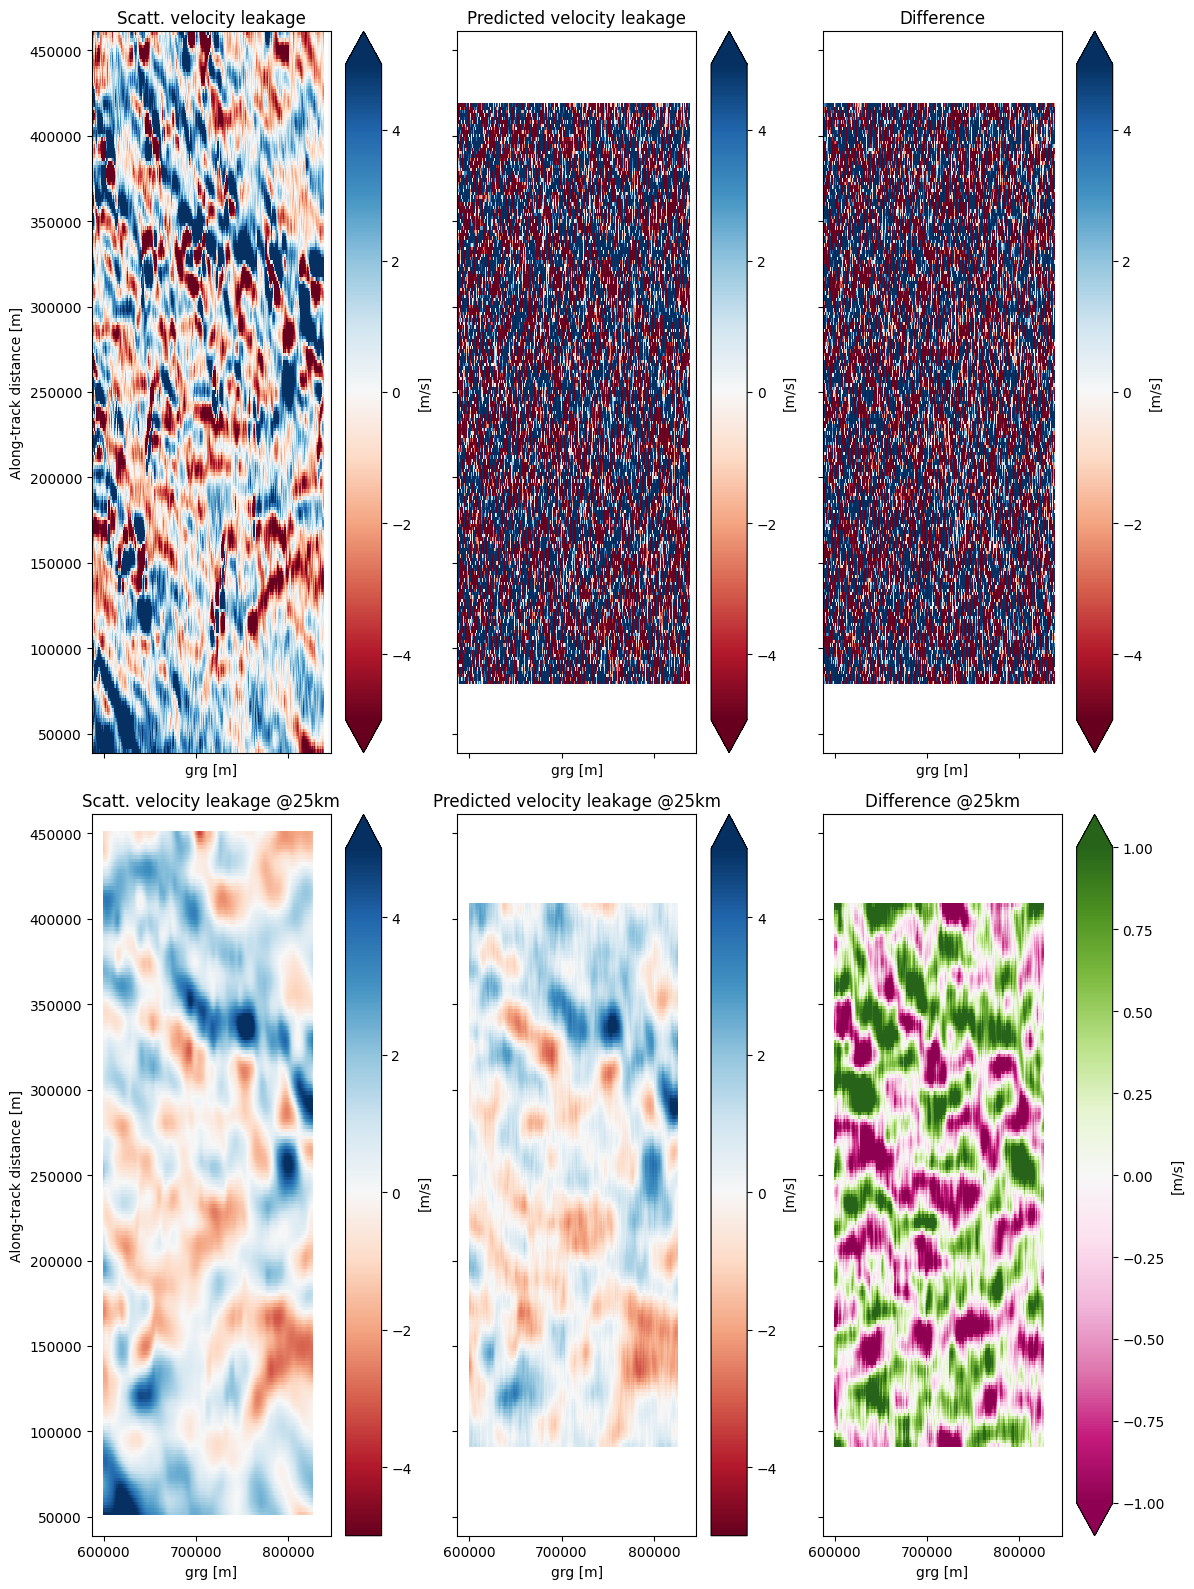

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(12, 16), sharex=True, sharey=True)

vmin = -5
vmax = 5

data.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data.V_leakage_pulse_rg_inverted.T.plot(robust = True, ax=axes[0,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data.V_leakage_pulse_rg.T - data.V_leakage_pulse_rg_inverted.T).plot(robust = True, ax=axes[0,2], vmin=vmin, vmax=vmax,cmap='RdBu', cbar_kwargs={"label": "[m/s]"})

axes[0,0].set_ylabel('Along-track distance [m]')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')
axes[0,0].set_title('Scatt. velocity leakage')
axes[0,1].set_title('Predicted velocity leakage')
axes[0,2].set_title('Difference')

data.V_leakage_pulse_rg_subscene.T.plot(robust = True, ax=axes[1,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data.V_leakage_pulse_rg_subscene_inverted.T.plot(robust = True, ax=axes[1,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data.V_leakage_pulse_rg_subscene.T - data.V_leakage_pulse_rg_subscene_inverted.T).plot(robust = True, ax=axes[1,2], vmin=vmin/5, vmax=vmax/5,cmap='PiYG', cbar_kwargs={"label": "[m/s]"})

axes[1,0].set_ylabel('Along-track distance [m]')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')
axes[1,0].set_title('Scatt. velocity leakage @25km')
axes[1,1].set_title('Predicted velocity leakage @25km')
axes[1,2].set_title('Difference @25km')

fig.tight_layout()

Text(0, 0.5, 'Along-track distance [m]')

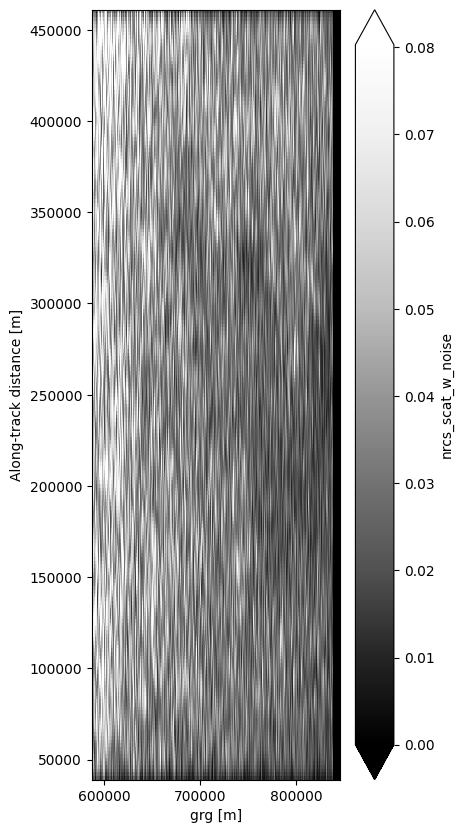

In [63]:
data.nrcs_scat.T.plot(robust=True, cmap= 'Greys_r', figsize=(4,10), aspect='auto', vmin = 0)
plt.ylabel('Along-track distance [m]')

## All scenes 

### - Without speckle noise

In [51]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")
scenarios.sort()
scenarios

['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Aghulas_20190515_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Aghulas_20191110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Azores_20201127_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel

In [52]:
for scenario in scenarios:
    start = scenario.rfind('processed/') + 10
    stop = scenario.find('_4ML')
    name = scenario[start:stop]
    
    dir_sinc = scenario.replace("phased_array", "sinc")
    dir_phased_array = scenario

    pa_data = xr.open_dataset(dir_phased_array)
    sinc_data = xr.open_dataset(dir_sinc)
    phased_array = pa_data.V_leakage_pulse_rg_subscene
    phased_array_inverted = pa_data.V_leakage_pulse_rg_subscene_inverted
    sinc = sinc_data.V_leakage_pulse_rg_subscene
    sinc_inverted = sinc_data.V_leakage_pulse_rg_subscene_inverted
    
    diff_phased_array = phased_array - phased_array_inverted
    diff_sinc = sinc - sinc_inverted

    perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2)), np.nanmedian(diff_phased_array)
    perf_sinc = np.sqrt(np.nanmean(diff_sinc**2)), np.nanmedian(diff_sinc)

    print(f"sinc,   RMSE: {perf_sinc[0]:.3f} m/s, median error: {perf_sinc[1]:.3f} m/s, scenario: {name}")
    print(f"phased, RMSE: {perf_phased_array[0]:.3f} m/s, median error: {perf_phased_array[1]:.3f} m/s")
    

sinc,   RMSE: 0.452 m/s, median error: 0.001 m/s, scenario: Aghulas_20190515
phased, RMSE: 0.697 m/s, median error: 0.002 m/s
sinc,   RMSE: 0.211 m/s, median error: 0.042 m/s, scenario: Aghulas_20191110
phased, RMSE: 0.337 m/s, median error: 0.063 m/s
sinc,   RMSE: 0.304 m/s, median error: 0.037 m/s, scenario: Azores_20201127
phased, RMSE: 0.460 m/s, median error: 0.057 m/s
sinc,   RMSE: 0.183 m/s, median error: 0.023 m/s, scenario: Barbedos_20201110
phased, RMSE: 0.284 m/s, median error: 0.035 m/s
sinc,   RMSE: 0.189 m/s, median error: 0.004 m/s, scenario: Carrib_20231104
phased, RMSE: 0.294 m/s, median error: 0.003 m/s
sinc,   RMSE: 0.223 m/s, median error: -0.006 m/s, scenario: Hawaii_20201106
phased, RMSE: 0.346 m/s, median error: -0.008 m/s
sinc,   RMSE: 0.228 m/s, median error: -0.003 m/s, scenario: Iceland_20231107
phased, RMSE: 0.347 m/s, median error: -0.007 m/s
sinc,   RMSE: 0.208 m/s, median error: -0.016 m/s, scenario: Morroco_20201103
phased, RMSE: 0.313 m/s, median error:

### - With speckle noise

In [ ]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")
scenarios.sort()
scenarios

['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Aghulas_20190515_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Aghulas_20191110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Azores_20201127_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200_spekN.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel

In [37]:
for scenario in scenarios:
    start = scenario.rfind('processed/') + 10
    stop = scenario.find('_4ML')
    name = scenario[start:stop]
    
    dir_sinc = scenario.replace("phased_array", "sinc")
    dir_phased_array = scenario

    pa_data = xr.open_dataset(dir_phased_array)
    sinc_data = xr.open_dataset(dir_sinc)
    phased_array = pa_data.V_leakage_pulse_rg_subscene
    phased_array_inverted = pa_data.V_leakage_pulse_rg_subscene_inverted
    sinc = sinc_data.V_leakage_pulse_rg_subscene
    sinc_inverted = sinc_data.V_leakage_pulse_rg_subscene_inverted
    
    diff_phased_array = phased_array - phased_array_inverted
    diff_sinc = sinc - sinc_inverted

    perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2)), np.nanmedian(diff_phased_array)
    perf_sinc = np.sqrt(np.nanmean(diff_sinc**2)), np.nanmedian(diff_sinc)

    print(f"sinc,   RMSE: {perf_sinc[0]:.3f} m/s, median error: {perf_sinc[1]:.3f} m/s, scenario: {name}")
    print(f"phased, RMSE: {perf_phased_array[0]:.3f} m/s, median error: {perf_phased_array[1]:.3f} m/s")
    

sinc,   RMSE: 0.723 m/s, median error: 0.002 m/s, scenario: Aghulas_20190515
phased, RMSE: 1.071 m/s, median error: 0.012 m/s
sinc,   RMSE: 0.555 m/s, median error: 0.158 m/s, scenario: Aghulas_20191110
phased, RMSE: 0.779 m/s, median error: 0.154 m/s
sinc,   RMSE: 0.556 m/s, median error: 0.071 m/s, scenario: Azores_20201127
phased, RMSE: 0.795 m/s, median error: 0.111 m/s
sinc,   RMSE: 0.487 m/s, median error: 0.035 m/s, scenario: Barbedos_20201110
phased, RMSE: 0.642 m/s, median error: 0.055 m/s
sinc,   RMSE: 0.498 m/s, median error: 0.017 m/s, scenario: Carrib_20231104
phased, RMSE: 0.636 m/s, median error: 0.063 m/s
sinc,   RMSE: 0.525 m/s, median error: -0.007 m/s, scenario: Hawaii_20201106
phased, RMSE: 0.738 m/s, median error: 0.036 m/s
sinc,   RMSE: 0.520 m/s, median error: 0.026 m/s, scenario: Iceland_20231107
phased, RMSE: 0.729 m/s, median error: 0.055 m/s
sinc,   RMSE: 0.505 m/s, median error: -0.026 m/s, scenario: Morroco_20201103
phased, RMSE: 0.673 m/s, median error: -0